In [1]:
from typing import Union, Optional
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.set_printoptions(linewidth=160)
np.random.seed(42)

# Catalytic Model:
## Combination of work from class and extending the model for HW 1

In [2]:
POPULATION_PER_AGE = 1000
MAX_AGE = 50
NUM_YEARS = 50


def deterministic_catalytic_model(
    lambda_by_year: Optional[np.ndarray] = None,
    lambda_by_age_params: Optional[list[Union[int, float]]] = None,
    include_births: bool = True,
    deterministic: bool = True,
) -> np.ndarray:
    """
    :param lambda_by_year: Infection rate by year
    :param lambda_by_age_params: Infection rate by age
        This is a 1D array of length 3 where the entries are [lambda_a, lambda_b, A_1]
        where lambda(a) = lambda_a if age <= A_1
        and lambda(a) = lambda_b if age > A_1
    :param include_births: Include births in the model
    :param deterministic: If True, use deterministic model

    :return: SI_out: Susceptible and Infected by age group and year
    """
    # susceptible and Infected by age group and year
    SI_out = np.zeros((NUM_YEARS+1, MAX_AGE+1, 3))

    # Initial first year
    SI_out[0, :, 0] = POPULATION_PER_AGE

    if include_births:
        # 100 Births every year
        SI_out[:, 0, 0] = POPULATION_PER_AGE

    if isinstance(lambda_by_year, np.ndarray):
        lambda_by_year_and_age = np.repeat(lambda_by_year.reshape(-1, 1), MAX_AGE, axis=1)

    elif lambda_by_age_params:
        A_1 = lambda_by_age_params[2] + 1
        lambda_a = lambda_by_age_params[0]
        lambda_b = lambda_by_age_params[1]

        lambda_by_age = np.zeros(MAX_AGE + 1)
        lambda_by_age[:A_1] = lambda_a
        lambda_by_age[A_1:] = lambda_b

        lambda_by_year_and_age = np.repeat(lambda_by_age.reshape(1, -1), NUM_YEARS, axis=0)

    else:
        raise ValueError("Either lambda_by_year or lambda_by_age must be provided.")

    for y_num in range(NUM_YEARS):
        for a_num in range(MAX_AGE):
            curr_susceptible = SI_out[y_num, a_num, 0]
            curr_infection = SI_out[y_num, a_num, 1]

            curr_lamb = min(lambda_by_year_and_age[y_num, a_num], 1)

            # TODO: In the future make this a binomial random variable which uses 
            #   this as a probability for each susceptible person to be infected.
            created_infections = curr_susceptible * curr_lamb

            new_susceptible = curr_susceptible - created_infections
            new_infection = curr_infection + created_infections

            SI_out[y_num + 1, a_num + 1, 0] = new_susceptible
            SI_out[y_num + 1, a_num + 1, 1] = new_infection
            SI_out[y_num, a_num, 2] = created_infections

    return SI_out


def sum_squared_error(
    ground_truth: np.ndarray,
    best_guess: np.ndarray,
) -> float:
    return ((ground_truth - best_guess)**2).sum()


def objective_function(
    lambda_by_year: np.ndarray,
    infections_by_year_gt: np.ndarray,
) -> float:
    SI_out = deterministic_catalytic_model(lambda_by_year)
    infections_by_year_guess = SI_out[:NUM_YEARS, :MAX_AGE, 2].sum(axis=1)
    return sum_squared_error(infections_by_year_gt, infections_by_year_guess)

In [3]:
lambda_by_year = np.random.uniform(0.05, 0.15, NUM_YEARS)
SI_out = deterministic_catalytic_model(lambda_by_year=lambda_by_year)

infections_by_year_gt = SI_out[:NUM_YEARS, :MAX_AGE, 2].sum(axis=1)

In [4]:
initial_guess = np.random.uniform(0.05, 0.15, NUM_YEARS)
SI_out_guess = deterministic_catalytic_model(lambda_by_year=initial_guess)
infections_by_year_guess = SI_out_guess[:NUM_YEARS, :MAX_AGE, 2].sum(axis=1)

In [5]:
results_nm = minimize(
    objective_function,
    x0=initial_guess,
    args=(infections_by_year_gt,),
    method="Nelder-Mead",
    options={"maxiter": 10000},
)

results_bfgs = minimize(
    objective_function,
    x0=np.ones(NUM_YEARS) * 0.1,
    args=(infections_by_year_gt,),
    method="L-BFGS-B",
    bounds=[(0.01, 0.25)] * NUM_YEARS,
    options={"maxiter": 100},
)


In [6]:
nm_lambda_si_out = deterministic_catalytic_model(results_nm.x)
bfgs_lambda_si_out = deterministic_catalytic_model(results_bfgs.x)
infections_by_year_nm_res = nm_lambda_si_out[:NUM_YEARS, :MAX_AGE, 2].sum(axis=1)
infections_by_year_bfgs_res = bfgs_lambda_si_out[:NUM_YEARS, :MAX_AGE, 2].sum(axis=1)

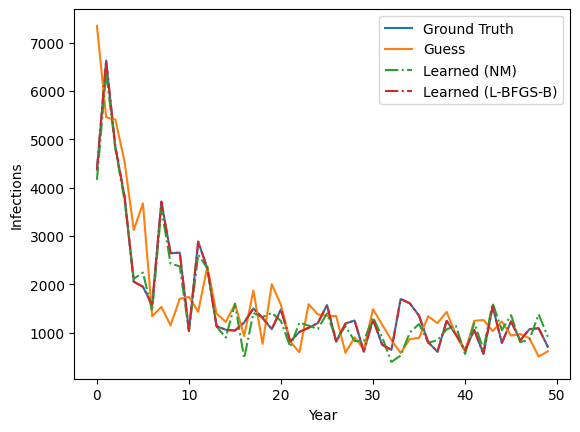

In [7]:
plt.plot(infections_by_year_gt, label="Ground Truth")
plt.plot(infections_by_year_guess, label="Guess")
plt.plot(infections_by_year_nm_res, '-.', label="Learned (NM)")
plt.plot(infections_by_year_bfgs_res, '-.', label="Learned (L-BFGS-B)")
plt.ylabel("Infections")
plt.xlabel("Year")
plt.legend()
plt.show()

## Variations HW 1

In [8]:
def plot_infections_by_age_cohort(
    SI_out: np.ndarray,
    ages: list[int],
    is_ground_truth: bool = True,
    fig: Optional[plt.Figure] = None,
    axs: Optional[np.ndarray] = None,
) -> None:
    """
    Plot the infections by age cohort.

    :param SI_out: Susceptible and Infected by age group and year
    :param ages: List of ages to plot
    :param is_ground_truth: If True, plot the ground truth
    :param fig: Figure to plot on
    :param axs: Axes to plot on

    :return: fig, axs
    """
    if not fig or not axs:
        fig_height = len(ages) * 16 // 4
        fig, axs = plt.subplots(len(ages), 2, figsize=(10, fig_height))

    ax = axs.flat

    label = "Ground Truth" if is_ground_truth else "Learned"

    # Turn this is into a forloop where you pass in a value k to get the right diagonal
    for i, age in enumerate(ages):
        susceptible_starting_at_age = np.diag(SI_out[:, :, 0], k=age)
        infections_starting_at_age = np.diag(SI_out[:, :, 1], k=age)

        ax[i*2].plot(infections_starting_at_age[:-1], label=label)
        ax[i*2].set_title(f"New Infections\n(Cohort starting at age {age + 1})")
        ax[i*2].set_xlabel("Year of Study (up to 50 years)")
        
        ax[i*2 + 1].plot(susceptible_starting_at_age[:-1]/POPULATION_PER_AGE, label=label)
        ax[i*2 + 1].set_title(f"Percentage (%) still susceptible\n(Cohort starting at age {age + 1})")
        ax[i*2 + 1].set_xlabel("Year of Study (up to 50 years)")

    plt.tight_layout()
    
    return fig, axs

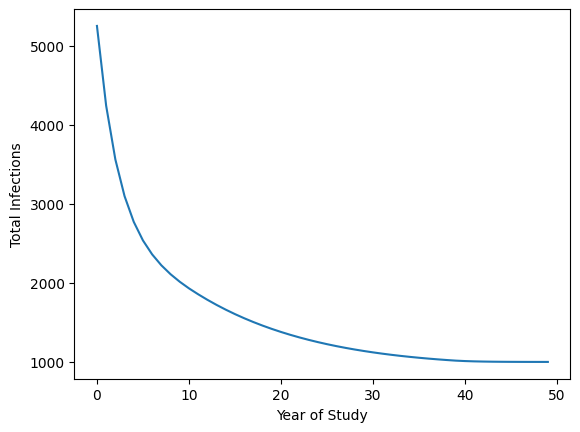

In [9]:
foi_by_age_gt = deterministic_catalytic_model(
    lambda_by_age_params=[0.3, 0.05, 10]
)

plt.plot(foi_by_age_gt[:NUM_YEARS, :MAX_AGE, 2].sum(axis=1))
plt.ylabel("Total Infections")
plt.xlabel("Year of Study")
plt.show()

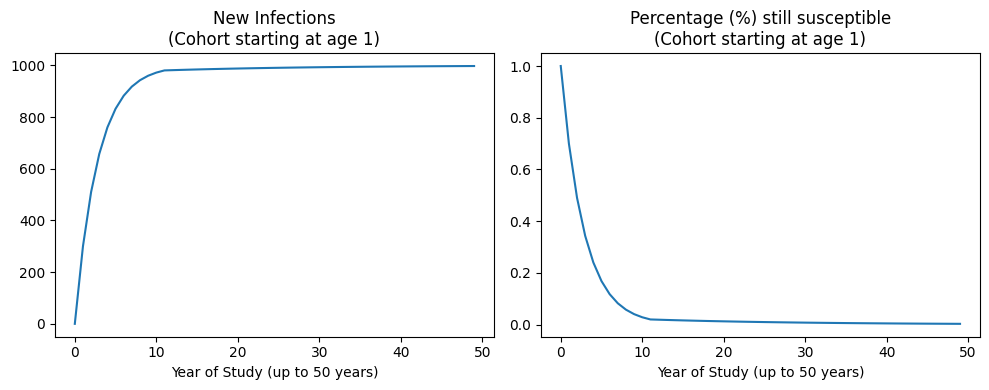

In [10]:
fig, axs = plot_infections_by_age_cohort(
    foi_by_age_gt,
    ages=[0],
)

(<Figure size 1000x1600 with 8 Axes>,
 array([[<Axes: title={'center': 'New Infections\n(Cohort starting at age 10)'}, xlabel='Year of Study (up to 50 years)'>,
         <Axes: title={'center': 'Percentage (%) still susceptible\n(Cohort starting at age 10)'}, xlabel='Year of Study (up to 50 years)'>],
        [<Axes: title={'center': 'New Infections\n(Cohort starting at age 20)'}, xlabel='Year of Study (up to 50 years)'>,
         <Axes: title={'center': 'Percentage (%) still susceptible\n(Cohort starting at age 20)'}, xlabel='Year of Study (up to 50 years)'>],
        [<Axes: title={'center': 'New Infections\n(Cohort starting at age 30)'}, xlabel='Year of Study (up to 50 years)'>,
         <Axes: title={'center': 'Percentage (%) still susceptible\n(Cohort starting at age 30)'}, xlabel='Year of Study (up to 50 years)'>],
        [<Axes: title={'center': 'New Infections\n(Cohort starting at age 40)'}, xlabel='Year of Study (up to 50 years)'>,
         <Axes: title={'center': 'Percentage

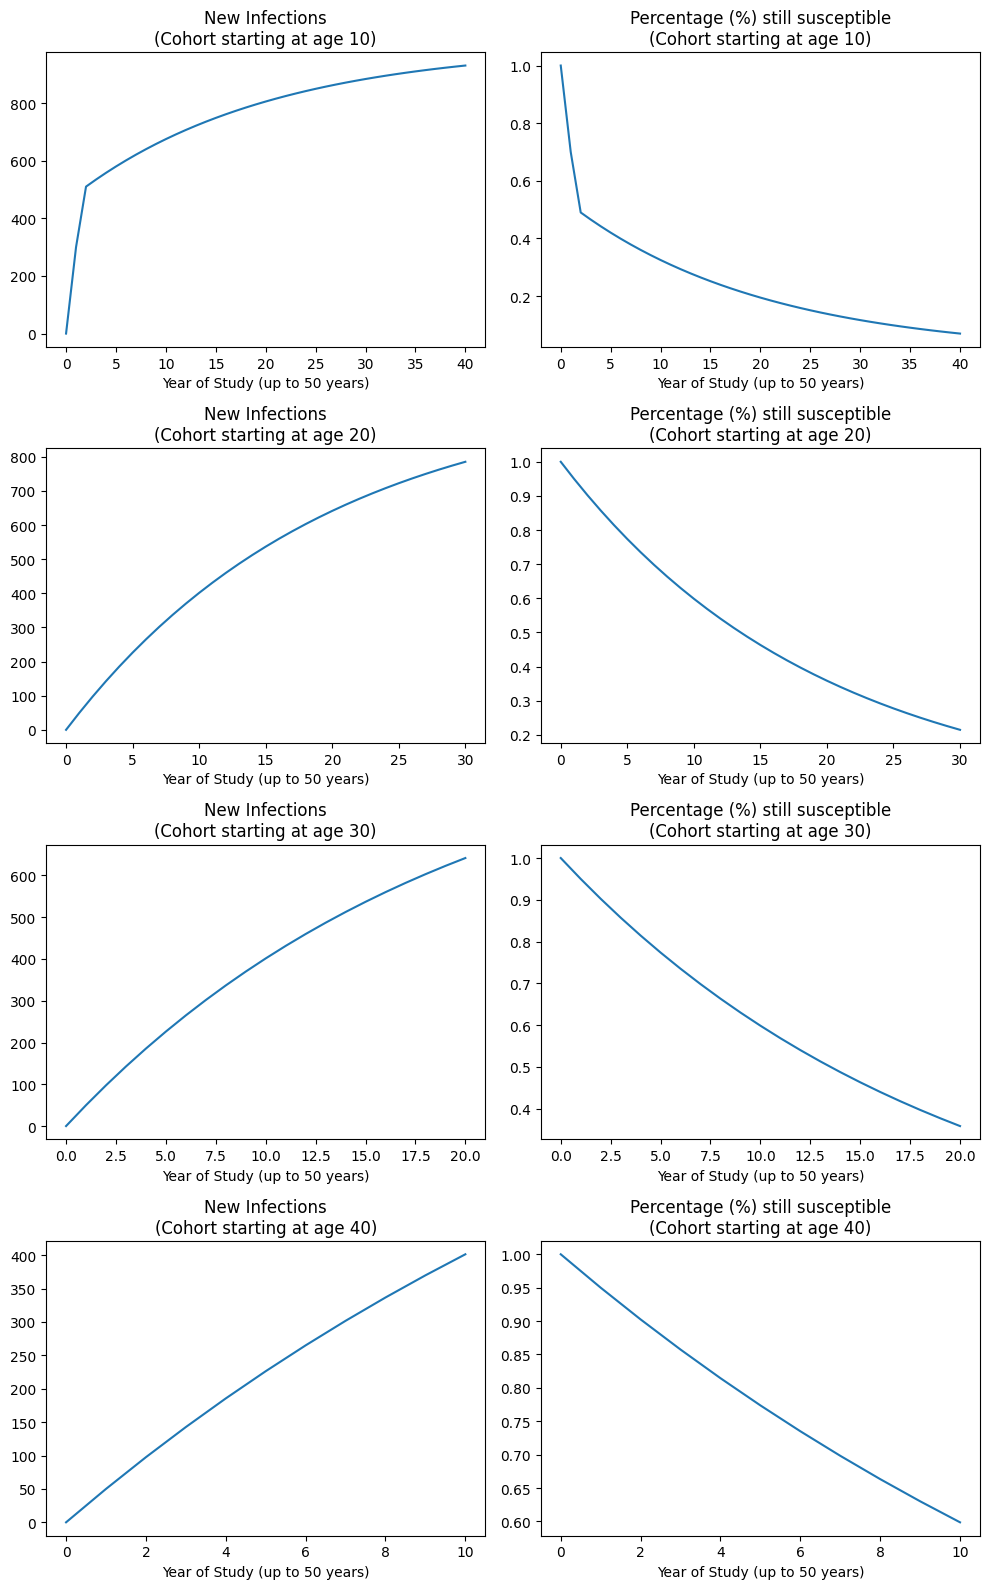

In [11]:
plot_infections_by_age_cohort(
    foi_by_age_gt,
    ages=[9, 19, 29, 39],
)

In [12]:
# TODO: Get ready to optimize to learn the lambda_a, lambda_b params given A_1.
#   Then further to learn them all without any of that information. Consider using
#   the functools partial to reparamaterize the model